In [1]:
!pip install numpy==1.16.1
#!pip install keras==2.1.2

from __future__ import print_function
import math
import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Layer, Dense, Dropout, Embedding, LSTM, CuDNNLSTM, Bidirectional
from keras.layers import Softmax
from keras.datasets import imdb

def get_lstm(size, return_sequences=True):
    return CuDNNLSTM(size, return_sequences=return_sequences)

max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_val = x_test[0:len(x_test)//2]
y_val = x_test[0:len(y_test)//2]
x_test = x_test[len(x_test)//2 : ]
y_test = x_test[len(y_test)//2 : ]
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print(len(x_val), 'validation sequences')

def compress(x, y):
    xout = []
    yout = []
    for i in range(len(x)):
        if x[i][0] != 0:
            xout.append(x[i])
            yout.append(y[i])
    xa = np.array(xout)
    print(xa.shape)
    return np.array(xout), np.array(yout)

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
x_val = sequence.pad_sequences(x_val, maxlen=maxlen)
#y_train = np.array(y_train)
#y_test = np.array(y_test)
y_train = np.expand_dims(np.array(x_train), -1)
y_test = np.expand_dims(np.array(x_test), -1)
y_val = np.expand_dims(np.array(x_val), -1)
(x_train, y_train) = compress(x_train, y_train)
(x_test, y_test) = compress(x_test, y_test)
(x_val, y_val) = compress(x_val, y_val)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_val shape:', x_val.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('y_val shape:', y_val.shape)



Using TensorFlow backend.


Loading data...
25000 train sequences
12500 test sequences
12500 validation sequences
Pad sequences (samples x time)
(22227, 100)
(11012, 100)
(11025, 100)
x_train shape: (22227, 100)
x_test shape: (11012, 100)
x_val shape: (11025, 100)
y_train shape: (22227, 100, 1)
y_test shape: (11012, 100, 1)
y_val shape: (11025, 100, 1)


In [0]:
# https://github.com/philipperemy/keras-snail-attention/blob/master/attention.py
class AttentionBlock(Layer):

    def __init__(self, dims, k_size, v_size, seq_len=None, **kwargs):
        self.k_size = k_size
        self.seq_len = seq_len
        self.v_size = v_size
        self.dims = dims
        self.sqrt_k = math.sqrt(k_size)
        self.keys_fc = None
        self.queries_fc = None
        self.values_fc = None
        super(AttentionBlock, self).__init__(**kwargs)

    def build(self, input_shape):
        # https://stackoverflow.com/questions/54194724/how-to-use-keras-layers-in-custom-keras-layer
        self.keys_fc = Dense(self.k_size)
        self.keys_fc.build((None, self.dims))
        self._trainable_weights.extend(self.keys_fc.trainable_weights)

        self.queries_fc = Dense(self.k_size)
        self.queries_fc.build((None, self.dims))
        self._trainable_weights.extend(self.queries_fc.trainable_weights)

        self.values_fc = Dense(self.v_size)
        self.values_fc.build((None, self.dims))
        self._trainable_weights.extend(self.values_fc.trainable_weights)

    def call(self, inputs, **kwargs):
        # check that the implementation matches exactly py torch.
        keys = self.keys_fc(inputs)
        queries = self.queries_fc(inputs)
        values = self.values_fc(inputs)
        logits = K.batch_dot(queries, K.permute_dimensions(keys, (0, 2, 1)))
        mask = K.ones_like(logits) * np.triu((-np.inf) * np.ones(logits.shape.as_list()[1:]), k=1)
        logits = mask + logits
        probs = Softmax(axis=-1)(logits / self.sqrt_k)
        read = K.batch_dot(probs, values)
        output = K.concatenate([inputs, read], axis=-1)
        return output

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        output_shape[-1] += self.v_size
        return tuple(output_shape)



In [3]:
def sparse_categorical_accuracy(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

def sparse_categorical_accuracy_per_sequence(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.min(K.cast(K.equal(y_true, y_pred_labels), K.floatx()), axis=-1)

def sparse_categorical_accuracy(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

def sparse_categorical_accuracy_per_sequence(y_true, y_pred):
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.min(K.cast(K.equal(y_true, y_pred_labels), K.floatx()), axis=-1)

def sparse_top_k_categorical_accuracy(y_true, y_pred, k=5):
    # If the shape of y_true is (num_samples, 1), flatten to (num_samples,)
    return K.cast(K.in_top_k(y_pred, K.cast(K.flatten(y_true), 'int32'), k),
                  K.floatx())

def sparse_top_k_categorical_accuracy_per_sequence(y_true, y_pred, k=5):
    # If the shape of y_true is (num_samples, 1), flatten to (num_samples,)
    return K.cast(K.in_top_k(y_pred, K.cast(K.flatten(y_true), 'int32'), k),
                  K.floatx())

def sparse(y_true, y_pred):
    return sparse_categorical_accuracy(y_true, y_pred)
def sequence(y_true, y_pred):
    return sparse_categorical_accuracy_per_sequence(y_true, y_pred)
def sparse_k(y_true, y_pred):
    return sparse_top_k_categorical_accuracy(y_true, y_pred)
def sequence_k(y_true, y_pred):
    return sparse_categorical_accuracy_top_k_per_sequence(y_true, y_pred)

def test_top_k_categorical_accuracy():
    y_pred = K.variable(np.array([[0.3, 0.2, 0.1], [0.1, 0.2, 0.7]]))
    y_true = K.variable(np.array([[0, 1, 0], [1, 0, 0]]))
    success_result = K.eval(metrics.top_k_categorical_accuracy(y_true, y_pred,
                                                               k=3))
    assert np.mean(success_result) == 1
    partial_result = K.eval(metrics.top_k_categorical_accuracy(y_true, y_pred,
                                                               k=2))
    assert np.mean(partial_result) == 0.5
    failure_result = K.eval(metrics.top_k_categorical_accuracy(y_true, y_pred,
                                                               k=1))
    assert np.mean(failure_result) == 0


units=16
units_k=units*2
units_v=13

model = Sequential()
model.add(Embedding(max_features, units*2, input_length=maxlen))
model.add(Bidirectional(get_lstm(units, return_sequences=True)))
model.add(Dropout(0.5))
if False:
    model.add(AttentionBlock(units*2, k_size=units_k, v_size=units_v))  # (80, 37) - looks correct.
    #model.add(Dense(units))
    model.add(Dropout(0.1))

model.add(Dense(max_features, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'sparse_categorical_crossentropy', metrics=[sparse, sequence])
model.summary()

print('Train...')
history = None
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=30,
          verbose=2,
          validation_data=[x_test, y_test])

W0620 05:02:57.860814 140073301493632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0620 05:02:57.877881 140073301493632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0620 05:02:57.880655 140073301493632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0620 05:02:58.959769 140073301493632 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0620 05:02:58.970731 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           640000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 32)           6400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 100, 20000)        660000    
Total params: 1,306,400
Trainable params: 1,306,400
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 22227 samples, validate on 11012 samples
Epoch 1/30
 - 106s - loss: 6.7391 - sparse: 0.0511 - sequence: 0.0000e+00 - val_loss: 6.0531 - val_sparse: 0.0552 - val_sequence: 0.0000e+00
Epoch 2/30
 - 102s - loss: 5.9399 - sparse: 0.0548 - sequence: 0

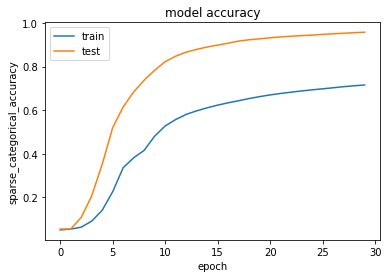

In [4]:

if history != None:
  # summarize history for accuracy
  plt.plot(history.history['sparse'])
  plt.plot(history.history['val_sparse'])
  plt.title('model accuracy')
  plt.ylabel('sparse_categorical_accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [5]:
short = x_val[0:100]

if True:
#with tf.Session() as session:
#  K.set_session(session)
#  session.run(tf.global_variables_initializer())
#  session.run(tf.tables_initializer())
  #model.load_weights('./model.h5')  
  eval = model.evaluate(x_val, y_val)
  print('model.evaluate on val holdout: ' ,model.metrics_names, eval)
  print('history: ', history)
  predicts = model.predict(short, batch_size=32)
  print('shape: {}'.format(predicts.shape))

print(len(predicts[0]))
print(len(predicts[0][0]))
#print(predicts[0])

11025/11025 [==============================] - 20s 2ms/step
model.evaluate on val holdout:  ['loss', 'sparse', 'sequence'] [0.4464581141342111, 0.9574503398320031, 0.03637188208684359]
history:  <keras.callbacks.History object at 0x7f64fe4ada90>
shape: (100, 100, 20000)
100
20000


In [6]:
def maxindx(pred):
    maxi=-1
    maxv=-1.0
    for x in range(len(pred)):
        if pred[x] > maxv:
            maxv = pred[x]
            maxi = x
    return (maxi, maxv)

def match(data, prediction):
    good = 0
    total = 0
    for i in range(len(data)):
        if data[i] == np.argmax(prediction[i]):
            good += 1
        total += 1
    #print('{}, {}'.format(good, total))
    if (total == 0):
        return 0
    return good / total

parallel = 0.0
serial = 0.0
total = 0
for n in range(len(short)):
    #print(short[n][0:5])
    check = match(short[n], predicts[n])
    parallel += check
    if check > 0.9999:
        serial += 1
    total += 1

print('Parallel, serial: ', parallel / total, serial / total)


Parallel, serial:  0.9543999999999998 0.05
